In [2]:
import numpy as np
import matplotlib.pyplot as plt
import galois
from classical_code import *
from quantum_code import *
import os

In [69]:
H = np.array([
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0],
[0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0],
[0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
[0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1],
[0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0],
[0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
[1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
[1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0],
[0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0],
[1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0],
[0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0],
[0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0]
])

dv = 3
dc = 4
GF = galois.GF(2)
m,n = H.shape
print(H.shape)

f_name = f'../codes/ccodes/{n}_{m}_{dv}_{dc}_2.code'

bit_nbhd = []
for bit in range(n):
    checks = np.where(H[:, bit])[0]
    bit_nbhd.append(checks)

check_nbhd = []
for check in range(m):
    bits = np.where(H[check])[0]
    check_nbhd.append(bits)

ccode = ClassicalCode(n, m, dv, dc, bit_nbhd, check_nbhd)

# hgp(ccode, "./codes/qcodes/")
write_code(f_name, ccode)

(18, 24)


In [112]:
GF = galois.GF(2)
ccode = read_code("../codes/ccodes/24_18_3_4_2.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
H = GF(H)
m, n = H.shape
print(H)

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0]
 [0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]]


In [113]:
def gaussian_reduction(H):
    m, n = H.shape

    H = GF(H)
    Hhat = GF(H.copy())
    K = GF(np.eye(n, dtype=int))
    pik = set(np.arange(n))

    for j in range(n):
        i = 0
        while ((i < m-1) and (Hhat[i][j] != 1)):
            i += 1
        if Hhat[i][j] == 1:
            pik ^= {j}
            for l in range(j+1, n):
                if Hhat[i][l] == 1:
                    Hhat[:,l] = Hhat[:,j] ^ Hhat[:,l]
                    K[:,l] = K[:,j] ^ K[:,l]

    return K, pik

In [114]:
K, pik = gaussian_reduction(H)
I = np.eye(n, dtype=int)
pik

{18, 19, 20, 21, 22, 23}

In [115]:
Lx = []
Lz = []

for i in pik:
    for j in pik:
        tmp = np.kron(K[:,i], I[:,j])
        # tmp = tmp.reshape(n,n)
        Lz.append(tmp)

        tmp = np.kron(I[:,i], K[:,j])
        # tmp = tmp.reshape(n,n)
        Lx.append(tmp)

Lx = np.array(Lx)
Lz = np.array(Lz)

In [116]:
# K, pik = gaussian_reduction(H.T)
# I = np.eye(H.T.shape[1], dtype=int)
# pik

In [118]:
H = np.array(H)
Hx = np.hstack([np.kron(H, np.eye(H.shape[1], dtype=int)), np.kron(np.eye(H.shape[0], dtype=int), H.T)])
Hz = np.hstack([np.kron(np.eye(H.shape[1], dtype=int), H), np.kron(H.T, np.eye(H.shape[0], dtype=int))])
cm, cn = Hx.shape

Hx_inds = [np.where(Hx[i])[0] for i in range(Hx.shape[0])]
Hz_inds = [np.where(Hz[i])[0] for i in range(Hz.shape[0])]

xL_inds = [np.where(x)[0] for x in Lx]
zL_inds = [np.where(z)[0] for z in Lz]
k = len(xL_inds)

qcode = QuantumCode(cn, k, Hz.shape[0], Hz.shape[0],
                    0, 0,
                    Hx_inds, Hz_inds, xL_inds, zL_inds, [])
write_qcode("../codes/qcodes/" + f"/HGP_{cn}_{k}_2.qcode", qcode)


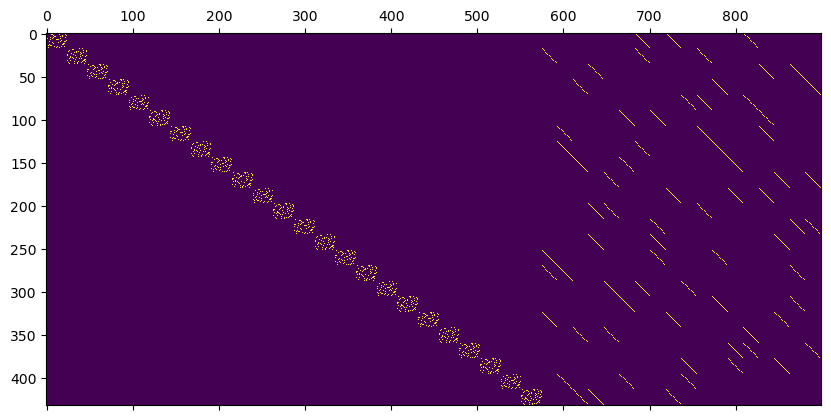

In [94]:
plt.matshow(np.array(Hz))

In [95]:
xgens = []
zgens = []

for i in range(Hx.shape[0]):
    xgens.append((Hx[i][:n**2].reshape(n,n), Hx[i][n**2:].reshape(m,m)))
    zgens.append((Hz[i][:n**2].reshape(n,n), Hz[i][n**2:].reshape(m,m)))

In [96]:
H

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 1, 0

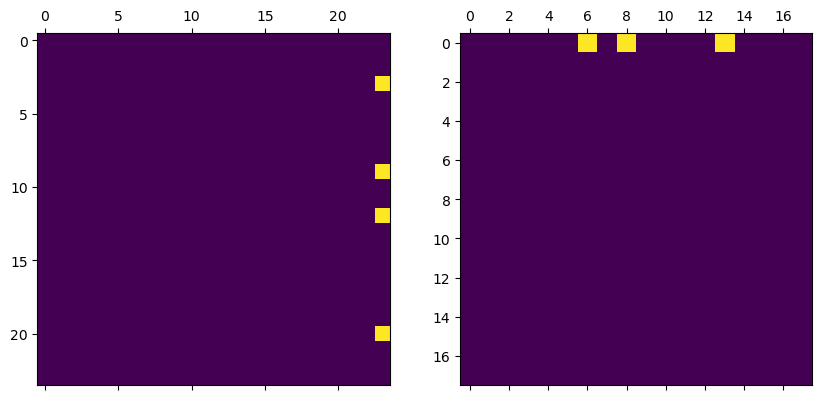

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

axes[0].matshow(xgens[-1][0])
axes[1].matshow(xgens[0][1])

In [98]:
Lx[3].reshape(n,n)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0

In [99]:
Lz[3].reshape(n,n)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0

In [100]:
inds = np.arange(Hx.shape[1])
left, right = (inds[:n**2].reshape(n,n), inds[n**2:].reshape(m,m))
print(left)
print(right)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23]
 [ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
   42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
   66  67  68  69  70  71]
 [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
  114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
  138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167]
 [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
  186 187 188 189 190 191]
 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
  210 211 212 213 214 215]
 [216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
  234 235 236 237

In [101]:
def assign_qubits(left, right):
    pairs = np.concatenate([np.diagonal(left), np.diagonal(right)]).reshape(-1, 2)

    upper_triangle_inds = np.triu_indices(left.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([left[i][j], left[j][i]])
        pairs = np.vstack([pairs, tmp])

    upper_triangle_inds = np.triu_indices(right.shape[0], k=1)
    for i, j in zip(*upper_triangle_inds):
        tmp = np.array([right[i][j], right[j][i]])
        pairs = np.vstack([pairs, tmp])

    return pairs

pairs = assign_qubits(left, right)
pairs

array([[  0,  25],
       [ 50,  75],
       [100, 125],
       [150, 175],
       [200, 225],
       [250, 275],
       [300, 325],
       [350, 375],
       [400, 425],
       [450, 475],
       [500, 525],
       [550, 575],
       [576, 595],
       [614, 633],
       [652, 671],
       [690, 709],
       [728, 747],
       [766, 785],
       [804, 823],
       [842, 861],
       [880, 899],
       [  1,  24],
       [  2,  48],
       [  3,  72],
       [  4,  96],
       [  5, 120],
       [  6, 144],
       [  7, 168],
       [  8, 192],
       [  9, 216],
       [ 10, 240],
       [ 11, 264],
       [ 12, 288],
       [ 13, 312],
       [ 14, 336],
       [ 15, 360],
       [ 16, 384],
       [ 17, 408],
       [ 18, 432],
       [ 19, 456],
       [ 20, 480],
       [ 21, 504],
       [ 22, 528],
       [ 23, 552],
       [ 26,  49],
       [ 27,  73],
       [ 28,  97],
       [ 29, 121],
       [ 30, 145],
       [ 31, 169],
       [ 32, 193],
       [ 33, 217],
       [ 34,

In [102]:
def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ

iceberg642Xlogicals = np.array([
    [1,2],
    [0,1],
    [4,5],
    [3,4],
])

iceberg642Zlogicals = np.array([
    [0,1],
    [1,2],
    [3,4],
    [4,5]
])

ibn = 4
ibk = ibn-2
icebergX = np.ones(ibn, dtype=int)
# icebergZ = np.ones(ibn, dtype=int)

# if (ibn == 6):
#     icebergXlogicals, icebergZlogicals = iceberg642Xlogicals, iceberg642Zlogicals
# else:
icebergXlogicals, icebergZlogicals = iceberglogicals(ibn)
print(icebergXlogicals)
print(icebergZlogicals)

[[0 1]
 [0 2]]
[[1 3]
 [2 3]]


In [103]:
# Hx, Hz, Lx, Lz = qcode.to_numpy()
concatenatedStabilizersQED = np.kron(np.eye(Hx.shape[1]//ibk, dtype=int), icebergX) # ibk | Hx.shape[1] required

concatenatedStabilizersXQEC = np.zeros(shape=(Hx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedStabilizersZQEC = np.zeros(shape=(Hz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Hx):
    # print(np.where(r))
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedStabilizersXQEC[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Hz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedStabilizersZQEC[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

concatenatedHx = np.vstack([concatenatedStabilizersXQEC, concatenatedStabilizersQED][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersZQEC, concatenatedStabilizersQED][::-1])

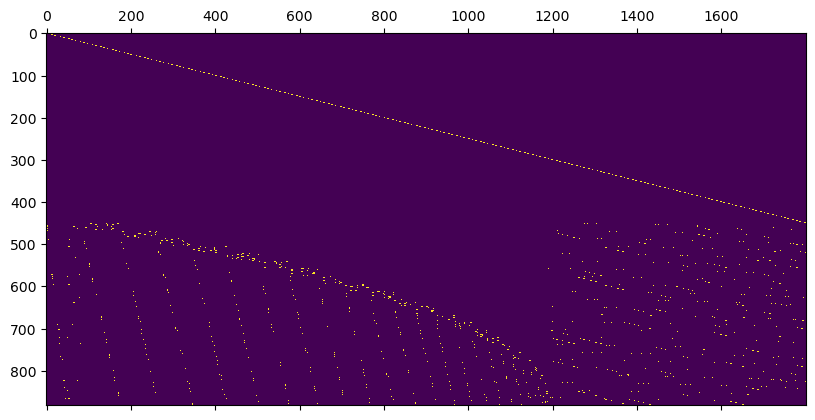

In [104]:
plt.matshow(concatenatedHz)

In [105]:
concatenatedxL = np.zeros(shape=(Lx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(Lz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Lx):
    for x in np.where(r)[0]:
        iceberg_block = np.where(pairs == x)[0][0]
        iceberg_log = np.where(pairs == x)[1][0]
        # print(iceberg_block, iceberg_log)
        concatenatedxL[i][icebergXlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

for i, r in enumerate(Lz):
    for z in np.where(r)[0]:
        iceberg_block = np.where(pairs == z)[0][0]
        iceberg_log = np.where(pairs == z)[1][0]
        concatenatedzL[i][icebergZlogicals[iceberg_log]+(ibn*iceberg_block)] ^= 1

xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

m, n = concatenatedHx.shape
k = len(xL_inds)

Hx_inds = [np.where(concatenatedHx[i])[0] for i in range(concatenatedHx.shape[0])]
Hz_inds = [np.where(concatenatedHz[i])[0] for i in range(concatenatedHz.shape[0])]

qcode = QuantumCode(n, k, concatenatedHx.shape[0], concatenatedHz.shape[0],
                    concatenatedStabilizersQED.shape[0], concatenatedStabilizersQED.shape[0],
                    Hx_inds, Hz_inds, xL_inds, zL_inds, list(pairs))
write_qcode("../codes/qcodes/" + f"/HGP_C{ibn}{ibk}2_{n}_{k}.qcode", qcode)

In [274]:
zL_inds

[array([13, 15, 49, 51, 73, 75, 93, 95], dtype=int64),
 array([ 53,  55,  77,  79,  97,  99, 137, 139], dtype=int64),
 array([109, 111, 121, 123, 129, 131, 138, 139], dtype=int64),
 array([ 14,  15, 113, 115, 125, 127, 133, 135], dtype=int64)]

In [275]:
xL_inds

[array([12, 13, 48, 50, 72, 74, 92, 94], dtype=int64),
 array([108, 110, 120, 122, 128, 130, 136, 137], dtype=int64),
 array([ 52,  54,  76,  78,  96,  98, 136, 138], dtype=int64),
 array([ 12,  14, 112, 114, 124, 126, 132, 134], dtype=int64)]